# Get model to use as encoder and comparator

In [1]:

from torchvision.datasets import ImageFolder
from src.utils.config import RESNET34_FULL
from src.utils.config import BEETLE_DATASET
from src.models import download_model, load_model_weights_and_metrics
import torchvision
import torch.nn as nn
import torch
from torch.utils.data import DataLoader
from src.GAM import GAM_fit

In [2]:
dataset_config = BEETLE_DATASET
model_config = RESNET34_FULL

In [3]:
model = download_model(model_config, dataset_config)
_ = load_model_weights_and_metrics(model, model_config)

In [4]:
model = model.to('cuda:0')

# Data for Generator

In [5]:
transformer = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 448)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(0.5, 0.5)])


In [6]:
gamset = ImageFolder(dataset_config['image_folder_path'], transform = transformer)
dataloader = DataLoader(gamset, batch_size = 16, num_workers = 12, shuffle=True)

# Discriminator and generator

In [7]:
def norm_img(img, mean, std):
    res = (img + 1) / 2
    return (res - mean) / std

In [8]:
def norm_latent(y):
    ret = y - torch.min(y)
    return ret / torch.max(ret)

In [9]:
class D_block(nn.Module):
    def __init__(self, out_channels, in_channels=3, kernel_size=4, strides=2,
                padding=1, alpha=0.2, **kwargs):
        super(D_block, self).__init__(**kwargs)
        self.conv2d = nn.Conv2d(in_channels, out_channels, kernel_size,
                                strides, padding, bias=False)
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.activation = nn.LeakyReLU(alpha, inplace=True)

    def forward(self, X):
        return self.activation(self.batch_norm(self.conv2d(X)))

In [10]:
n_D = 64
net_D = nn.Sequential(
    D_block(n_D),  # Output: (64, 32, 32)
    D_block(in_channels=n_D, out_channels=n_D*2),  # Output: (64 * 2, 16, 16)
    D_block(in_channels=n_D*2, out_channels=n_D*4),  # Output: (64 * 4, 8, 8)
    D_block(in_channels=n_D*4, out_channels=n_D*8),  # Output: (64 * 8, 4, 4)
    D_block(in_channels=n_D*8, out_channels=n_D*16),  # Output: (64 * 8, 4, 4)
    nn.Conv2d(in_channels=n_D*16, out_channels=1,
              kernel_size=(7,14), bias=False))  # Output: (1, 1, 1)

In [11]:
class G_block(nn.Module):
    def __init__(self, out_channels, in_channels=3, kernel_size=(4,4), strides=(2,2),
                 padding=(1,1), **kwargs):
        super(G_block, self).__init__(**kwargs)
        self.conv2d_trans = nn.ConvTranspose2d(in_channels, out_channels,
                                kernel_size, strides, padding, bias=False)
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.activation = nn.ReLU()

    def forward(self, X):
        return self.activation(self.batch_norm(self.conv2d_trans(X)))

In [12]:
n_G = 64
net_G = nn.Sequential(
    G_block(in_channels=197, out_channels=n_G*16, kernel_size=(7,14),
            strides=1, padding=0),                  # Output: (64 * 16, 7, 14)
    G_block(in_channels=n_G*16, out_channels=n_G*8), # Output: (64 * 8, 14, 28)
    G_block(in_channels=n_G*8, out_channels=n_G*4), # Output: (64 * 4, 28, 56)
    G_block(in_channels=n_G*4, out_channels=n_G*2), # Output: (64 * 2, 56, 112)
    G_block(in_channels=n_G*2, out_channels=n_G),   # Output: (64, 112, 224)
    nn.ConvTranspose2d(in_channels=n_G, out_channels=3,
                       kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh())  # Output: (3, 224, 448)


for w in net_D.parameters():
        nn.init.normal_(w, 0, 0.02)
for w in net_G.parameters():
        nn.init.normal_(w, 0, 0.02)

# Apply the damn thing!!!!!!!!!

0.39600292909155727
0.1668912234249247
208.77261506155858
19.99687565452403
228.93638159891293


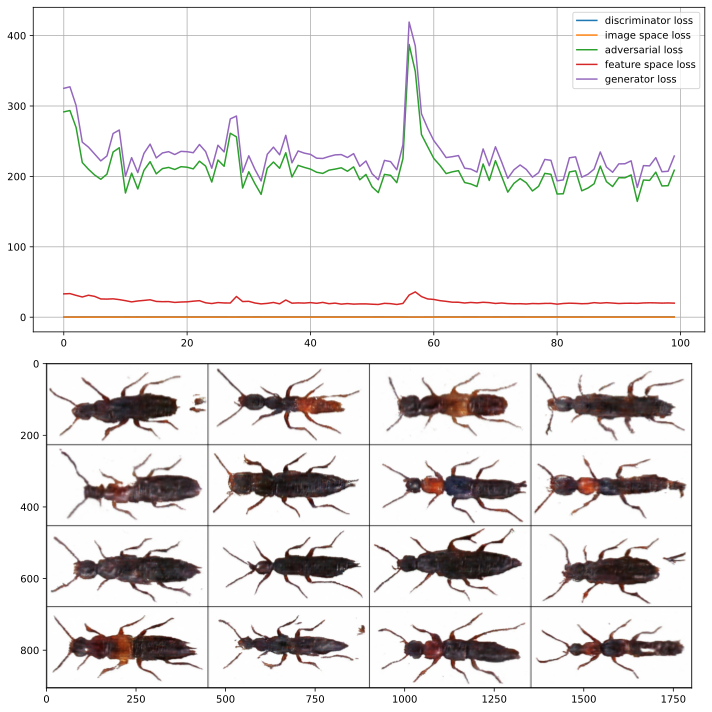

Training complete in 309m 32s


In [13]:
gen = GAM_fit(net_G, net_D, model, norm_img, norm_latent, dataloader, num_epochs=100)

In [14]:
torch.save(gen.state_dict(), 'Gen_02' )